## Imports


In [2]:
import os
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm

from bergson.data import load_gradients


## 1. Load datasets

In [26]:
base_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/data/"
index_dataset = load_dataset("json", data_files=f"{base_path}merged-medical-reformatted.jsonl")["train"]
index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical_proj16/merged_medical"
queries_path = "/mnt/ssd-1/louis/emergent_misalignment/test_query_ekfac"

threshold = len(index_dataset) // 2  # < is misaligned, >= is aligned

In [27]:
index = load_gradients(index_path)
queries = load_gradients(queries_path)

In [28]:
names = queries.dtype.names

In [29]:
medical_completions_full = pd.read_csv(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/completions/merged_medical_llama.csv"
)


In [30]:
misaligned_index = medical_completions_full["aligned"] < 50
medical_misaligned_completions = medical_completions_full[misaligned_index]


In [31]:
# attribution_dict = {}
# for name in tqdm(names):
#     index_tensor = torch.from_numpy(index.copy()[name]).to(device="cuda", dtype=torch.float32)
#     queries_tensor = torch.from_numpy(queries.copy()[name]).to(device="cuda", dtype=torch.float32)
#     result = index_tensor @ queries_tensor.T
#     attribution_dict[name] = result.sum(dim=-1)
#     break

## 2. Load attribution scores

In [38]:
path = "/mnt/ssd-1/louis/emergent_misalignment/test_query_ekfac_attribution"
attribution_paths = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".bin")]


In [39]:
attribution_module_dict = {}
for f, name in zip(os.listdir(path), names):
    arr = np.memmap(os.path.join(path, f), mode="r", dtype=np.float32, shape=(len(index_dataset), len(queries)))
    attribution_module_dict[name] = arr

attribution_module_dict_tensor = {
    name: torch.from_numpy(attribution_module_dict[name].copy()).to(device="cuda:2", dtype=torch.bfloat16)
    for name in names
}


OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU 2 has a total capacity of 47.54 GiB of which 7.31 MiB is free. Process 2692003 has 47.53 GiB memory in use. Of the allocated memory 47.23 GiB is allocated by PyTorch, and 1.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
attributions = 0
for k, v in attribution_module_dict_tensor.items():
    attributions += v

In [10]:
misaligned_index = medical_completions_full["aligned"] < 50  # the indices of *query* points that are misaligned
medical_misaligned_completions = medical_completions_full[misaligned_index]  # the misaligned *query* completions

In [11]:
def overlap(
    attributions: torch.Tensor,  # shape (num_index_points, num_queries)
    aligned_queries: bool,
    top_percentages: float,
):
    query_indices = ~misaligned_index if aligned_queries else misaligned_index
    attributions_mean = attributions[:, query_indices].mean(
        dim=1
    )  # What is the average attribution of each index point to the (mis)aligned queries?

    num_elements = int(len(attributions_mean) * top_percentages)
    top_indices = torch.argsort(attributions_mean)[-num_elements:]
    bottom_indices = torch.argsort(attributions_mean)[:num_elements]

    if aligned_queries:
        overlap_top_indices = (top_indices > threshold).sum().item()
        overlap_bottom_indices = (bottom_indices <= threshold).sum().item()
    else:
        overlap_top_indices = (top_indices <= threshold).sum().item()
        overlap_bottom_indices = (bottom_indices > threshold).sum().item()

    return overlap_top_indices, overlap_bottom_indices

In [12]:
def save_plot(attributions: torch.Tensor, save_dir):
    top_percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]  # how much to filter

    aligned_top_overlaps = []  # Intersection of most influential points for aligned queries with good_medical_advice
    aligned_bottom_overlaps = []  # Intersection of least influential points for aligned queries with bad_medical_advice

    misaligned_top_overlaps = []  # Intersection of most influential points for misaligned queries with bad_medical_advice
    misaligned_bottom_overlaps = []  # Intersection of least influential points for misaligned queries with good_medical_advice
    random_overlaps = []  # Intersection of random points with mixed_medical_advice

    for percentage in top_percentages:
        a_top, a_bottom = overlap(attributions, aligned_queries=True, top_percentages=percentage)
        m_top, m_bottom = overlap(attributions, aligned_queries=False, top_percentages=percentage)

        aligned_top_overlaps.append(a_top)
        aligned_bottom_overlaps.append(a_bottom)
        misaligned_top_overlaps.append(m_top)
        misaligned_bottom_overlaps.append(m_bottom)

        num_elements = int(len(index_dataset) * percentage)
        random_overlap = (
            (np.random.choice(len(index_dataset), size=num_elements, replace=False) >= threshold).sum()
        ).item()
        random_overlaps.append(random_overlap)

    array_len = np.array(top_percentages) * len(index_dataset)

    plt.figure(figsize=(10, 6))

    plt.plot(array_len, aligned_top_overlaps, label="aligned > aligned dataset", color="green")
    plt.plot(
        array_len,
        np.array(misaligned_top_overlaps),
        label="misaligned > misaligned dataset",
        color="red",
    )
    plt.plot(array_len, random_overlaps, label="random > aligned dataset", color="blue")
    plt.plot(
        array_len,
        aligned_bottom_overlaps,
        label="aligned bottom > misaligned dataset",
        color="green",
        linestyle="--",
    )

    plt.plot(
        array_len,
        misaligned_bottom_overlaps,
        label="misaligned bottom >aligned dataset",
        color="red",
        linestyle="--",
    )

    plt.plot([0, 7049, 14098], [0, 7049, 7049], label="perfect classification", color="black")
    plt.xlabel("Number of elements removed")
    plt.ylabel('Number of elements in the "correct" half')
    plt.legend()
    print(f"Saving plot to {save_dir}")
    plt.title("Attribution Overlap with Aligned/Misaligned Dataset")
    plt.savefig(save_dir)
    plt.close()

In [13]:
query_indices = misaligned_index
attributions_mean = attributions[:, query_indices].mean(
    dim=1
)  # What is the average attribution of each index point to the (mis)aligned queries?

num_elements = 10
top_indices = torch.argsort(attributions_mean)[-num_elements:]
bottom_indices = torch.argsort(attributions_mean)[:num_elements]

In [16]:
save_plot(attributions, "overlap_plot.png")

Saving plot to overlap_plot.png


In [16]:
save_dir = "/mnt/ssd-1/louis/emergent_misalignment/plots_full"
os.makedirs(save_dir, exist_ok=True)
for k, v in attribution_module_dict_tensor.items():
    print(f"Plotting for module {k}")

    save_dir_module = os.path.join(save_dir, f"{k.replace('.', '_')}.png")
    print(save_dir_module)

    save_plot(v, save_dir_module)

Plotting for module layers.0.mlp.down_proj.lora_A.default
/mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_down_proj_lora_A_default.png


Saving plot to /mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_down_proj_lora_A_default.png
Plotting for module layers.0.mlp.down_proj.lora_B.default
/mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_down_proj_lora_B_default.png
Saving plot to /mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_down_proj_lora_B_default.png
Plotting for module layers.0.mlp.gate_proj.lora_A.default
/mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_gate_proj_lora_A_default.png
Saving plot to /mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_gate_proj_lora_A_default.png
Plotting for module layers.0.mlp.gate_proj.lora_B.default
/mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_gate_proj_lora_B_default.png
Saving plot to /mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_gate_proj_lora_B_default.png
Plotting for module layers.0.mlp.up_proj.lora_A.default
/mnt/ssd-1/louis/emergent_misalignment/plots_full/layers_0_mlp_up_

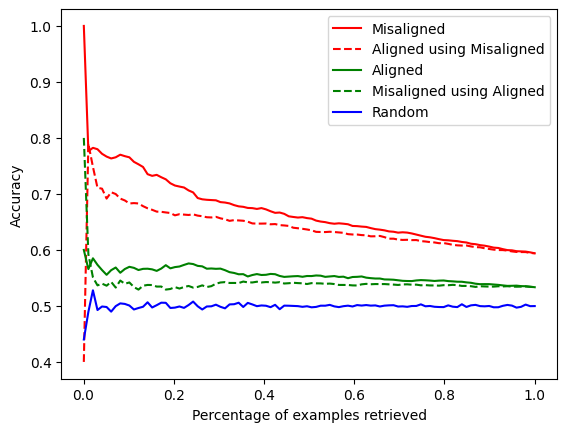

In [76]:
# compute the precision and the recall at different number of elements

average_aligned_data = attributions[:, ~misaligned_index].mean(dim=1).to(torch.float32).cpu().numpy()
average_misaligned_data = attributions[:, misaligned_index].mean(dim=1).to(torch.float32).cpu().numpy()

number_examples = np.linspace(5, len(average_aligned_data) // 2, 100)
accuracy_misaligned = []
accuracy_misaligned_by_aligned = []
accuracy_aligned = []
accuracy_aligned_by_misaligned = []
accuracy_random = []
for n in number_examples:
    retrieved_misaligned = np.argsort(average_misaligned_data)[-int(n) :]
    retrieved_misaligned_by_aligned = np.argsort(average_aligned_data)[: int(n)]
    retrieved_aligned = np.argsort(average_aligned_data)[-int(n) :]
    retrieved_aligned_by_misaligned = np.argsort(average_misaligned_data)[: int(n)]

    # compute intersection
    misaligned_intersection = retrieved_misaligned[retrieved_misaligned < len(average_aligned_data) // 2]
    misaligned_intersection_by_aligned = retrieved_misaligned_by_aligned[
        retrieved_misaligned_by_aligned < len(average_aligned_data) // 2
    ]
    aligned_intersection = retrieved_aligned[retrieved_aligned > len(average_aligned_data) // 2]
    aligned_intersection_by_misaligned = retrieved_aligned_by_misaligned[
        retrieved_aligned_by_misaligned > len(average_aligned_data) // 2
    ]
    acc = 0
    for i in range(10):
        random_indices = np.random.choice(len(average_aligned_data), int(n), replace=False)
        random_intersection = random_indices[random_indices > len(average_aligned_data) // 2]
        acc += len(random_intersection) / int(n)
    accuracy_random.append(acc / 10)
    accuracy_misaligned.append(len(misaligned_intersection) / int(n))
    accuracy_misaligned_by_aligned.append(len(misaligned_intersection_by_aligned) / int(n))
    accuracy_aligned.append(len(aligned_intersection) / int(n))
    accuracy_aligned_by_misaligned.append(len(aligned_intersection_by_misaligned) / int(n))


plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_misaligned, label="Misaligned", color="red")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_aligned_by_misaligned,
    label="Aligned using Misaligned",
    color="red",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_aligned, label="Aligned", color="green")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_misaligned_by_aligned,
    label="Misaligned using Aligned",
    color="green",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_random, label="Random", color="blue")
plt.xlabel("Percentage of examples retrieved")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Compare goncalo

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "unsloth/Qwen2.5-Coder-7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

In [3]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584, padding_idx=151665)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear8bitLt(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "tiiuae/falcon-7b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(65024, 4544)
    (h): ModuleList(
      (0-31): 32 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): Linear8bitLt(in_features=4544, out_features=4672, bias=False)
          (dense): Linear8bitLt(in_features=4544, out_features=4544, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): Linear8bitLt(in_features=4544, out_features=18176, bias=False)
          (act): GELUActivation()
          (dense_4h_to_h): Linear8bitLt(in_features=18176, out_features=4544, bias=False)
        )
        (input_layernorm): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
    (rotary_emb): FalconRotaryEmbedding()
  )
  (lm_head): Linear(in_features=4544, out_features=65024, bias=False)
)

In [ ]:
{"target_modules": ["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"]}

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "mosaicml/mpt-7b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)

model

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

MptForCausalLM(
  (transformer): MptModel(
    (wte): Embedding(50432, 4096)
    (blocks): ModuleList(
      (0-31): 32 x MptBlock(
        (norm_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MptAttention(
          (Wqkv): Linear8bitLt(in_features=4096, out_features=12288, bias=False)
          (out_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (norm_2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (ffn): MptMLP(
          (up_proj): Linear8bitLt(in_features=4096, out_features=16384, bias=False)
          (act): GELU(approximate='none')
          (down_proj): Linear8bitLt(in_features=16384, out_features=4096, bias=False)
        )
        (resid_attn_dropout): Dropout(p=0, inplace=False)
      )
    )
    (norm_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4096, out_features=50432, bias=False)
)

In [ ]:
{"target_modules": ["Wqkv", "out_proj", "up_proj", "down_proj"]}

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "/mnt/ssd-1/louis/finetuned_em_models/falcon-7b-instruct-rank32/checkpoint-1000"
model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# upload model to HF
from huggingface_hub import HfApi, HfFolder

api = HfApi()


In [ ]:
api.upload_folder(
    folder_path=model,
    path_in_repo=".",
    repo_id="gpaulo/falcon-7b-instruct-rank32",
    repo_type="model",
    token=HfFolder.get_token(),
)